In [1]:
import os
import pickle
import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt

from openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [2]:
class DataPlotter(object):
    
    def __init__(self, d_labels_to_info):
        """
        Parameters
        ----------
        d_labels_to_info : OrderedDict()
            contains free energy data for each experiment
            key : name of experiment (format: '{single letter amino acid of WT}{residue id}{single letter amino acid of mutant} 
                                                {phase} ({simulation type} r{replicate number})')
            value : dict with the following keys:
                key : list of file path(s) to free energy data
                key : list of starting indices to use in slicing the free energy data
                key : list of ending indices to use in slicing the free energy data
                key : total iterations to analyze 
            
            example: 
            d_labels_to_info = OrderedDict({
                "A42T complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              }
                })
        """
        
        # Set unsampled states
        self.first_unsampled_state_index = 0
        self.last_unsampled_state_index = -1
        
        # Load data
        data = OrderedDict()
        for i, (label, d_info) in enumerate(d_labels_to_info.items()):
            
            file_paths = d_info["file_paths"]
            slice_begs = d_info["slice_begs"]
            slice_ends = d_info["slice_ends"]
            total_iterations = d_info["total_iterations"]
            
            # Load free energy data
            for j, (file_path, slice_beg, slice_end) in enumerate(zip(file_paths, slice_begs, slice_ends)):
                
                if j == 0:
                    with open(file_path, "rb") as f:
                        results = pickle.load(f)
                    data[label] = {"results": results[slice_beg:slice_end]}
                
                else:
                    with open(file_path, "rb") as f:
                        results = pickle.load(f)
                    data[label]["results"] += results[slice_beg:slice_end]
            
            data[label]["total_iterations"] = total_iterations
                
        self.data = data
        
        # Set colors
        prop_cycle = plt.rcParams["axes.prop_cycle"]
        self.colors = prop_cycle.by_key()["color"]

    def _generate_bias_plot(self, save_path=None, override_title=None):
        """
        Generate bias (aka discrepancy) with respect to "true" dg plot
        Where "true" dg was determined from taking the average of 3 replicates of 100 ns/replica simulations
        
        Parameters
        ----------
        save_path : str
            filepath at which to save the figure
        override_title : str, default None
            title use instead of the experiment name in d_labels_info
        """
        # Set figure size
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(8, 5))
        
        # Assemble biases and errors -- each dict will contain subdicts for each replicate
        biases = {}
        errors = {}
        labels = []
        for i, (label, data) in enumerate(self.data.items()):
            
            # Retrieve label
            title = label.split("(")[0][:-1]
            experiment_label = label.split("(")[-1][:-1]
            replicate = experiment_label[-1]
            rest_label = experiment_label[:-3]
            if rest_label not in labels:
                labels.append(rest_label)
            
             # Set true free energy values
            if "A42T" in title:
                true_dg = -33.63 # averaged across repex trajs 45/9/replicate_0-2
            elif "R87A" in title:
                true_dg = 105.51 # averaged across repex trajs 45/10/replicate_0-2

            # Retrieve free energies and errors
            dgs = np.array([results["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for results in data["results"]])
            ddgs = np.array([results["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for results in data["results"]])
            
            # Store bias and error
            
            if replicate not in biases:
                biases[replicate] = [dgs[-1] - true_dg]
                errors[replicate] = [ddgs[-1]]
            else:
                biases[replicate].append(dgs[-1] - true_dg)
                errors[replicate].append(ddgs[-1])
        
        # Set colors
        colors = ["#FFDA00", "#fdb462", "#fb8072"]
        
        # Set font size
        plt.rc('font', size=15) 
        
        # Set marker size
        size = 100
        
        # Plot no rest experiment (average)
        biases = np.array([biases[r] for r in biases])
        errors = np.array([errors[r] for r in errors])
        plt.scatter(labels[0], np.mean(biases[:, 0]), color="#80b1d3", marker="o", label="no rest", s=size)
        
        # Plot no rest experiment (each replicate)
        for replicate in range(len(biases)):
            plt.scatter(labels[0], biases[replicate][0], color="#80b1d3", marker="+", label="no rest", alpha=0.5, s=size)
      
        # Make plot
        for i, label in enumerate(labels[1:]):
            
            # Plot the average
            plt.scatter(label, np.mean(biases[:, i+1]), color=colors[i%3], marker="o", label=label, s=size)
            
            # Plot each replicate
            for replicate in range(len(biases)):
                plt.scatter(label, biases[replicate][i+1], color=colors[i%3], marker="+", label=label, alpha=0.5, s=size)
        
        # Label axes   
        plt.xlabel("Rest parameter combination")
        DDG = r"$\Delta G_\mathrm{complex}$"
        plt.ylabel(f"{DDG} discrepancy\n(kcal/mol)")
        plt.xticks(rotation=45, ha='right')
        
        # Set y axis
        plt.ylim([-1, 6])
        
        # Set title
        if override_title:
            plt.title(override_title)
        else:
            plt.title(title)
        
        # Ensure x-axis labels are not cut off
        plt.tight_layout()
    
        # Save plot as pdf
        if save_path:
            plt.savefig(save_path, dpi=500)
            plt.show()
            plt.clf()
        else:
            plt.show()



# Retrieve "true" free energies

In [16]:
main_dir = 45
sub_dir = 9
phase = 'complex'
length = 100
dgs = []
for replicate in range(3):
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
        results = pickle.load(f)
        dgs.append(results["Deltaf"][0, -1]*KT_KCALMOL)
print("mean: ", np.mean(dgs))
print("stderr: ", np.std(dgs))

mean:  -33.632078639834624
stderr:  0.20294620849662107


In [17]:
main_dir = 45
sub_dir = 10
phase = 'complex'
length = 100
dgs = []
for replicate in range(3):
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
        results = pickle.load(f)
        dgs.append(results["Deltaf"][0, -1]*KT_KCALMOL)
print("mean: ",np.mean(dgs))
print("stderr: ", np.std(dgs))

mean:  105.50988496475792
stderr:  0.7531834936527076


# A42T complex 10 ns (3 replicates)

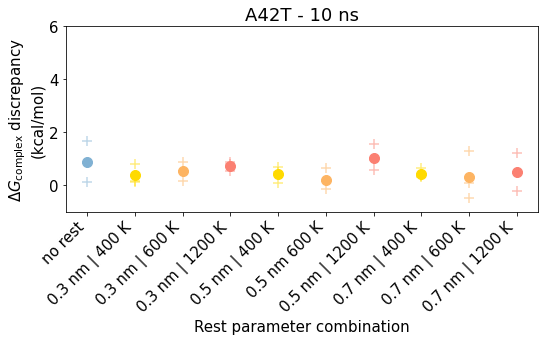

<Figure size 432x288 with 0 Axes>

In [17]:
main_dir_norest = 45
main_dir_rest = 49
phase = 'complex'
base_path_norest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_norest}"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"
sub_dir = "9"

d_labels_to_info = OrderedDict({
                    f"A42T complex (no rest r0)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "9", f"replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    "A42T complex (no rest r1)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "9", f"replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    "A42T complex (no rest r2)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "9", f"replicate_2", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
                    })

labels = ["0.3 nm | 400 K", "0.3 nm | 600 K", "0.3 nm | 1200 K", "0.5 nm | 400 K", "0.5 nm 600 K", "0.5 nm | 1200 K", "0.7 nm | 400 K", "0.7 nm | 600 K", "0.7 nm | 1200 K"]
for sub_dir in range(9):
    d_labels_to_info[f"A42T complex ({labels[sub_dir]} r0)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_0", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
    d_labels_to_info[f"A42T complex ({labels[sub_dir]} r1)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_1", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
    d_labels_to_info[f"A42T complex ({labels[sub_dir]} r2)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_2", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
    
save_path = os.path.join(base_path_rest, "A42T_10ns_bias_plot.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_bias_plot(override_title="A42T - 10 ns", save_path=save_path)

# R87A complex 10 ns (3 replicates)

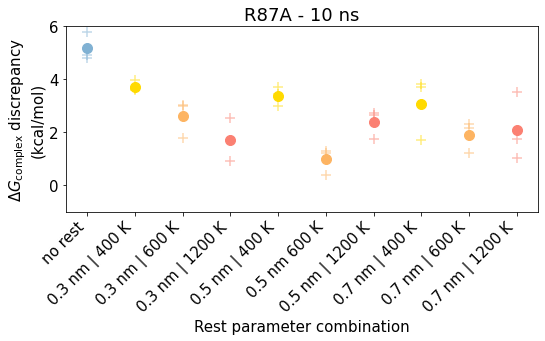

<Figure size 432x288 with 0 Axes>

In [18]:
main_dir_norest = 45
main_dir_rest = 49
phase = 'complex'
base_path_norest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_norest}"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"
sub_dir = "10"


d_labels_to_info = OrderedDict({
                    f"R87A complex (no rest r0)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "10", f"replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    "R87A complex (no rest r1)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "10", f"replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    "R87A complex (no rest r2)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "10", f"replicate_2", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    })

labels = ["0.3 nm | 400 K", "0.3 nm | 600 K", "0.3 nm | 1200 K", "0.5 nm | 400 K", "0.5 nm 600 K", "0.5 nm | 1200 K", "0.7 nm | 400 K", "0.7 nm | 600 K", "0.7 nm | 1200 K"]
for sub_dir in range(9, 18):

    d_labels_to_info[f"R87A complex ({labels[sub_dir-9]} r0)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_0", f"{phase}_free_energy_timeseries_1_30ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
    d_labels_to_info[f"R87A complex ({labels[sub_dir-9]} r1)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_1", f"{phase}_free_energy_timeseries_1_30ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
    d_labels_to_info[f"R87A complex ({labels[sub_dir-9]} r2)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_2", f"{phase}_free_energy_timeseries_1_30ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              }
    
save_path = os.path.join(base_path_rest, "R87A_10ns_bias_plot.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_bias_plot(override_title="R87A - 10 ns", save_path=save_path)

# A42T complex 2 ns (3 replicates)

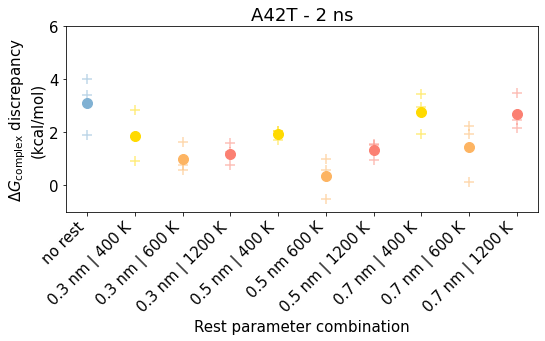

<Figure size 432x288 with 0 Axes>

In [19]:
main_dir_norest = 45
main_dir_rest = 49
phase = 'complex'
base_path_norest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_norest}"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"
sub_dir = "9"

d_labels_to_info = OrderedDict({
                    f"A42T complex (no rest r0)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "9", f"replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [2],
                                               "total_iterations": 2000,
                                              },
                    "A42T complex (no rest r1)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "9", f"replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [2],
                                               "total_iterations": 2000,
                                              },
                    "A42T complex (no rest r2)": {"file_paths": 
                                                   [os.path.join(base_path_norest, "9", f"replicate_2", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [2],
                                               "total_iterations": 2000,
                                              }
                    })

labels = ["0.3 nm | 400 K", "0.3 nm | 600 K", "0.3 nm | 1200 K", "0.5 nm | 400 K", "0.5 nm 600 K", "0.5 nm | 1200 K", "0.7 nm | 400 K", "0.7 nm | 600 K", "0.7 nm | 1200 K"]
for sub_dir in range(9):

    d_labels_to_info[f"A42T complex ({labels[sub_dir]} r0)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_0", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [2],
                                               "total_iterations": 2000,
                                              }
    d_labels_to_info[f"A42T complex ({labels[sub_dir]} r1)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_1", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [2],
                                               "total_iterations": 2000,
                                              }
    d_labels_to_info[f"A42T complex ({labels[sub_dir]} r2)"] = {"file_paths": 
                                                   [os.path.join(base_path_rest, str(sub_dir), f"replicate_2", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [2],
                                               "total_iterations": 2000,
                                              }

save_path = os.path.join(base_path_rest, "A42T_2ns_bias_plot.pdf")    
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_bias_plot(override_title="A42T - 2 ns", save_path=save_path)